In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/sales.csv')

In [3]:
df.dropna(subset=['price'], inplace=True)

In [4]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [5]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year

train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

# 1. Dummy Transformer

<font color='red'>Question:</font> What are dummy variables?

In [6]:
# Dummy variables are ones that take the value 1 or 0 to indicate the presence or absence in a category. Dummy variables are
# used in regression analysis.

**Example:** Class to transform **product_level** to dummy variables. 

In [7]:
class Dummy_Transformer(object):
    
    def fit(self, X, y=None):
        self.keys = set(X)
    
    def transform(self, X, y=None):
        res = {}
        for key in self.keys:
            res[key] = [0]*len(X)    
        for i, item in enumerate(X):
            if item in self.keys:
                res[item][i] = 1
        return pd.DataFrame(res)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)        

In [7]:
dummytf = Dummy_Transformer()

In [8]:
dummytf.fit_transform(df.product_level).head()

,advanced,intermediate,basic,unrated,super advanced
0,1,0,0,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,1,0,0,0,0
4,1,0,0,0,0


<font color='red'>Assignment:</font> Wrap up the above dummy transformer with LinearRegression as pipeline to predict **price**. 

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

steps = [('dtf', Dummy_Transformer()),
         ('lr', LinearRegression())]

model = Pipeline(steps)

In [12]:
y_train = train_raw['price'].map(lambda x: x if type(x) == float else float(x.strip('$').replace(',', '')))
y_test = test_raw['price'].map(lambda x: x if type(x) == float else float(x.strip('$').replace(',', '')))

In [18]:
model = model.fit(train_raw["product_level"], y_train)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_train_pred = model.predict(train_raw["product_level"])
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.34e+05
train MSE: 4.10e+10
train R2: 0.038


In [20]:
y_test_pred = model.predict(test_raw["product_level"])
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 1.64e+05
train MSE: 8.38e+10
train R2: 0.028


# 2. Frequence Transformer

<font color='red'>Assignment:</font> Write a class to replace the categorical values in **product_level** with their frequencies.

In [24]:
class Frequency_Transformer(object):
    
    def fit(self, X, y=None):
        self.keys = set(X)
    
    def transform(self, X, y=None):
        res = {}
        for key in self.keys:
            res[key] = [0]*len(X)    
        for i, item in enumerate(X):
            if item in self.keys:
                res[item][i] = 1
        df = pd.DataFrame(res)
        for col in list(df.columns):
            freq = df[col].sum()
            df[col] = df[col].map(lambda x: x*freq)
        return df
            
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X) 

In [26]:
frequencytf = Frequency_Transformer()
frequencytf.fit_transform(df.product_level).head(20)

,unrated,basic,advanced,intermediate,super advanced
0,0,0,1320,0,0
1,0,111,0,0,0
2,0,111,0,0,0
3,0,0,1320,0,0
4,0,0,1320,0,0
5,0,0,0,0,1222
6,0,0,0,0,1222
7,0,0,1320,0,0
8,0,0,0,0,1222
9,0,0,1320,0,0


<font color='red'>Assignment:</font> Plot the relationship between **product_level** frequencies and **price**.

Text(0, 0.5, 'price')

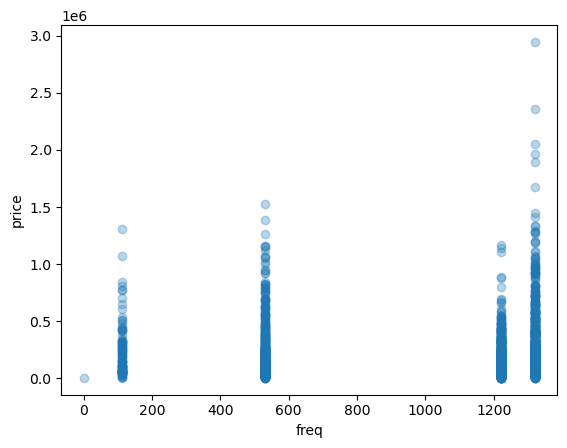

In [30]:
import matplotlib.pylab as plt
%matplotlib inline

df_freq = frequencytf.fit_transform(df.product_level)
df_freq["freq"] = df_freq.sum(axis = 1)
price_all = df['price'].map(lambda x: x if type(x) == float else float(x.strip('$').replace(',', '')))

plt.scatter(df_freq["freq"], price_all, alpha=0.3)
plt.xlabel('freq')
plt.ylabel('price')

# 3. Ordinal Transformer

<font color='red'>Assignment:</font> The relationships between the values in **product_level** can be represented by ordinal numbers. Write a class to replace the level values with their ordinal numbers.

In [36]:
class Ordinal_Transformer(object):
    
    def fit(self, X, y=None):
        self.keys = set(X)
    
    def transform(self, X, y=None):
        df = pd.DataFrame({"ordinal": [0] * len(X)})
        for i, item in enumerate(X):
            if item == "basic":
                df.iloc[i, 0] = 1
            elif item == "intermediate":
                df.iloc[i, 0] = 2
            elif item == "advanced":
                df.iloc[i, 0] = 3
            elif item == "super advanced":
                df.iloc[i, 0] = 4
            else:
                df.iloc[i, 0] = 0
        return df
            
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X) 

<font color='red'>Assignment:</font> Plot the relationship between **product_level** ordinal numbers and **price**.

In [37]:
ordinaltf = Ordinal_Transformer()
ordinaltf.fit_transform(df.product_level).head(20)

,ordinal
0,3
1,1
2,1
3,3
4,3
5,4
6,4
7,3
8,4
9,3


Text(0, 0.5, 'price')

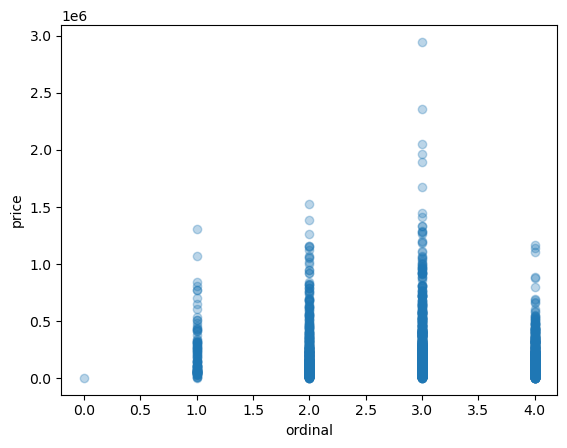

In [39]:
df_ordinal = ordinaltf.fit_transform(df.product_level)

plt.scatter(df_ordinal["ordinal"], price_all, alpha=0.3)
plt.xlabel('ordinal')
plt.ylabel('price')

# 4. Text Vectorization

Column **ingredient** is more complex. There are missing values. And also many rows contains multiple ingredients.

## 4.1 Missing values

<font color='red'>Assignment:</font> In **train_raw**, impute the missing values in **ingredient** as **unknown_ingredient**, and assign the imputed **ingredient** to a variable **train_imputed_ingredient**.

In [41]:
train_raw["train_imputed_ingredient"] = train_raw["ingredient"].map(lambda x: x if type(x) != float else "unknow_ingredient")
train_raw.head(20)

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth,year,train_imputed_ingredient
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm,2008,"IN732052,IN732053"
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm,1997,"IN732054,IN732055,IN732056,IN732057,IN732058"
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm,2001,"IN732054,IN732059,IN732060"
3,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm,2000,"IN732064,IN732065,IN732066"
4,$59k,"$60,320",2 Ton 930 Kg,Aug 19 2011,H,super advanced,M14124,"IN732067,IN732068,IN732069,IN732070,IN732071,I...",2.71 meters,96 cm,25 cm,2011,"IN732067,IN732068,IN732069,IN732070,IN732071,I..."
5,NaN,"$182,233",3 Ton 300 Kg,Oct 11 1996,S,super advanced,M14125,"IN732073,IN732074",3.01 meters,96 cm,25 cm,1996,"IN732073,IN732074"
6,NaN,"$41,155",3 Ton 80 Kg,Jan 08 2010,"B,A",advanced,M14126,IN732075,2.97 meters,94 cm,25 cm,2010,IN732075
7,$66k,"$180,759",3 Ton 330 Kg,Aug 01 2014,H,super advanced,NaN,"IN732076,IN732077,IN732073,IN732078,IN732079,I...",2.71 meters,102 cm,27 cm,2014,"IN732076,IN732077,IN732073,IN732078,IN732079,I..."
8,$119k,"$182,517",2 Ton 970 Kg,Feb 04 2005,"K,D",advanced,M14127,"IN732085,IN732086,IN732087",2.84 meters,94 cm,25 cm,2005,"IN732085,IN732086,IN732087"
9,$81k,"$228,868",2 Ton 940 Kg,Apr 04 2008,N,advanced,M14129,"IN732093,IN732094,IN732095,IN732096",2.52 meters,99 cm,26 cm,2008,"IN732093,IN732094,IN732095,IN732096"


<font color='red'>Questions:</font> What are other ways to impute or handle missing categorical values? What are the good ways to handle different amounts of missing categorical values, like a few lines, a small fraction (say 2%), a considerable fraction (say 30%), and majority (say 95%)?

In [ ]:
# Ways to handle missing categorical values:
# 0 impute the missing value as 'unknown'
# 1 Delete the row of the data
# 2 Replacing the missing value with the most frequent value
# 3 Develop a model to predict the missing value 
# 4 Deleting the variable
# 5 Applying unsupervised machine learning techniques
#
# If a few lines are missing, use method 0 and 1
# If a small fraction data are missing, use method 2
# If a considerable fraction of data are missing, use method 3 and 5
# if Majority of the data are missing, use method 4

## 4.2 Countvectorizer

**Example:** Import **CountVectorizer**

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

<font color='red'>Assignment:</font> Fit and transform **train_imputed_ingredient** using **CountVectorizer**. Assign the output to **X_train**.

In [43]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_raw["train_imputed_ingredient"])

<font color='red'>Assignment:</font> Get the type and shape of **X_train**. 

In [44]:
type(X_train)

scipy.sparse._csr.csr_matrix

In [47]:
X_train

<2757x1858 sparse matrix of type '<class 'numpy.int64'>'
	with 11832 stored elements in Compressed Sparse Row format>

<font color='red'>Question:</font> What is a sparse matrix?

In [48]:
# A sparse matrix is one that most of its elements have value 0

**Example**: Assign the output of **ingredient** generated with **CountVectorizer** to a DataFrame named **train_ingredient_df**, name the columns with features. 

In [50]:
train_ingredient_df = pd.DataFrame(X_train.todense())
train_ingredient_df = train_ingredient_df.rename(columns={v: k for k, v in vectorizer.vocabulary_.items()})
train_ingredient_df.head()

,in732052,in732053,in732054,in732055,in732056,in732057,in732058,in732059,in732060,in732061,...,in734073,in734074,in734075,in734076,in734079,in734080,in734081,in734086,in734087,unknow_ingredient
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<font color='red'>Assignment:</font> Train a new model using **Pipeline** to wrap up **CountVectorizer** and **LinearRegression** to predict **price**, and get both the train and test scores.

In [51]:
steps = [('cv', CountVectorizer()),
         ('lr', LinearRegression())]

model = Pipeline(steps)

model = model.fit(train_raw["train_imputed_ingredient"], y_train)

In [52]:
y_train_pred = model.predict(train_raw["train_imputed_ingredient"])
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 5.22e+04
train MSE: 6.94e+09
train R2: 0.837


In [54]:
test_raw["train_imputed_ingredient"] = test_raw["ingredient"].map(lambda x: x if type(x) != float else "unknow_ingredient")

In [55]:
y_test_pred = model.predict(test_raw["train_imputed_ingredient"])
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 4.65e+05
train MSE: 5.47e+11
train R2: -5.346
